## Investigates the gains for different entropy-coding schemes

In [1]:
import bench_utils
from algos.alg_fpd_extended import FpdExtended
from shapely.geometry import shape
from algos.fpd_extended_lib.compress import get_zz_encoded_delta
from algos.fpd_extended_lib.decompress import decode_header
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
fpde = FpdExtended()

In [14]:
# Load a bunch of data-sets
# chunks[delta_size] - contains a list of chunks, first indexed by the number of bits used per delta


from collections import defaultdict
from bitarray import bitarray
from algos.fpd_extended_lib import cfg

shape_cnt = 0
dt_to_coord = defaultdict()
dt_freq = defaultdict(lambda: defaultdict(int))
dt_xs = []
dt_ys = []
chunks = defaultdict(list)

def append_deltas(dataset):
    global shape_cnt
    df, idxs = bench_utils.read_dataset(dataset)
    for idx in idxs:
        shape_cnt += 1
        bin = fpde.compress(shape(df.iloc[idx]))[1]

        cfg.offset = 0
        delta_size, type = decode_header(bin)
        chks = fpde.get_chunks(bin, include_ring_start=False)[0]
        # Go though deltas
        for chk in chks:
            chk_dts = []
            for i in range(len(chk) - 1):
                dt_x = get_zz_encoded_delta(chk[i][0], chk[i + 1][0])
                dt_y = get_zz_encoded_delta(chk[i][1], chk[i + 1][1])
                dt_to_coord[dt_x] = chk[i + 1][0] - chk[i][0]
                dt_to_coord[dt_y] = chk[i + 1][1] - chk[i][1]
                dt_freq[delta_size][dt_x] += 1
                dt_freq[delta_size][dt_y] += 1
                dt_xs.append(dt_x)
                dt_ys.append(dt_y)
                chk_dts += [dt_x, dt_y]
            chunks[delta_size].append(chk_dts)

                


append_deltas("data/lund_building_highway.json")
append_deltas("data/world_7_dec.json")
append_deltas("data/sweden.json")

print(f"Number of shapes: {shape_cnt}")
print(f"Number of deltas: {len(dt_xs) + len(dt_ys)}")

Number of shapes: 121086
Number of deltas: 5381878


In [3]:
dt_freq_sorted = defaultdict(lambda: defaultdict(int))
for bit_size in sorted(dt_freq.keys()):
    freqs = sorted(dt_freq[bit_size].items(), key=lambda x: -x[1])
    dt_freq_sorted[bit_size] = freqs

print(dt_freq_sorted[12])

[(0, 2200), (857, 438), (858, 427), (54, 423), (322, 413), (53, 405), (25, 402), (108, 401), (1179, 387), (643, 378), (5, 372), (214, 370), (644, 369), (321, 367), (27, 356), (107, 354), (26, 352), (52, 352), (28, 350), (51, 350), (1180, 349), (105, 345), (13, 344), (6, 343), (3, 341), (213, 341), (536, 340), (16, 339), (535, 338), (9, 337), (10, 332), (8, 328), (17, 327), (1502, 325), (590, 324), (430, 323), (1716, 323), (966, 319), (589, 319), (7, 315), (15, 315), (106, 314), (4, 311), (21, 310), (11, 308), (14, 308), (55, 306), (429, 305), (23, 304), (12, 303), (1287, 303), (965, 301), (1501, 301), (29, 300), (750, 299), (697, 299), (267, 298), (24, 297), (31, 295), (79, 293), (749, 293), (35, 293), (1288, 292), (18, 292), (19, 290), (268, 290), (1715, 287), (160, 284), (911, 283), (50, 282), (45, 282), (162, 282), (48, 281), (2146, 280), (1, 279), (30, 275), (47, 274), (22, 274), (751, 273), (49, 273), (1071, 272), (912, 271), (56, 270), (209, 269), (2, 269), (376, 269), (80, 269),

<Figure size 2100x700 with 0 Axes>

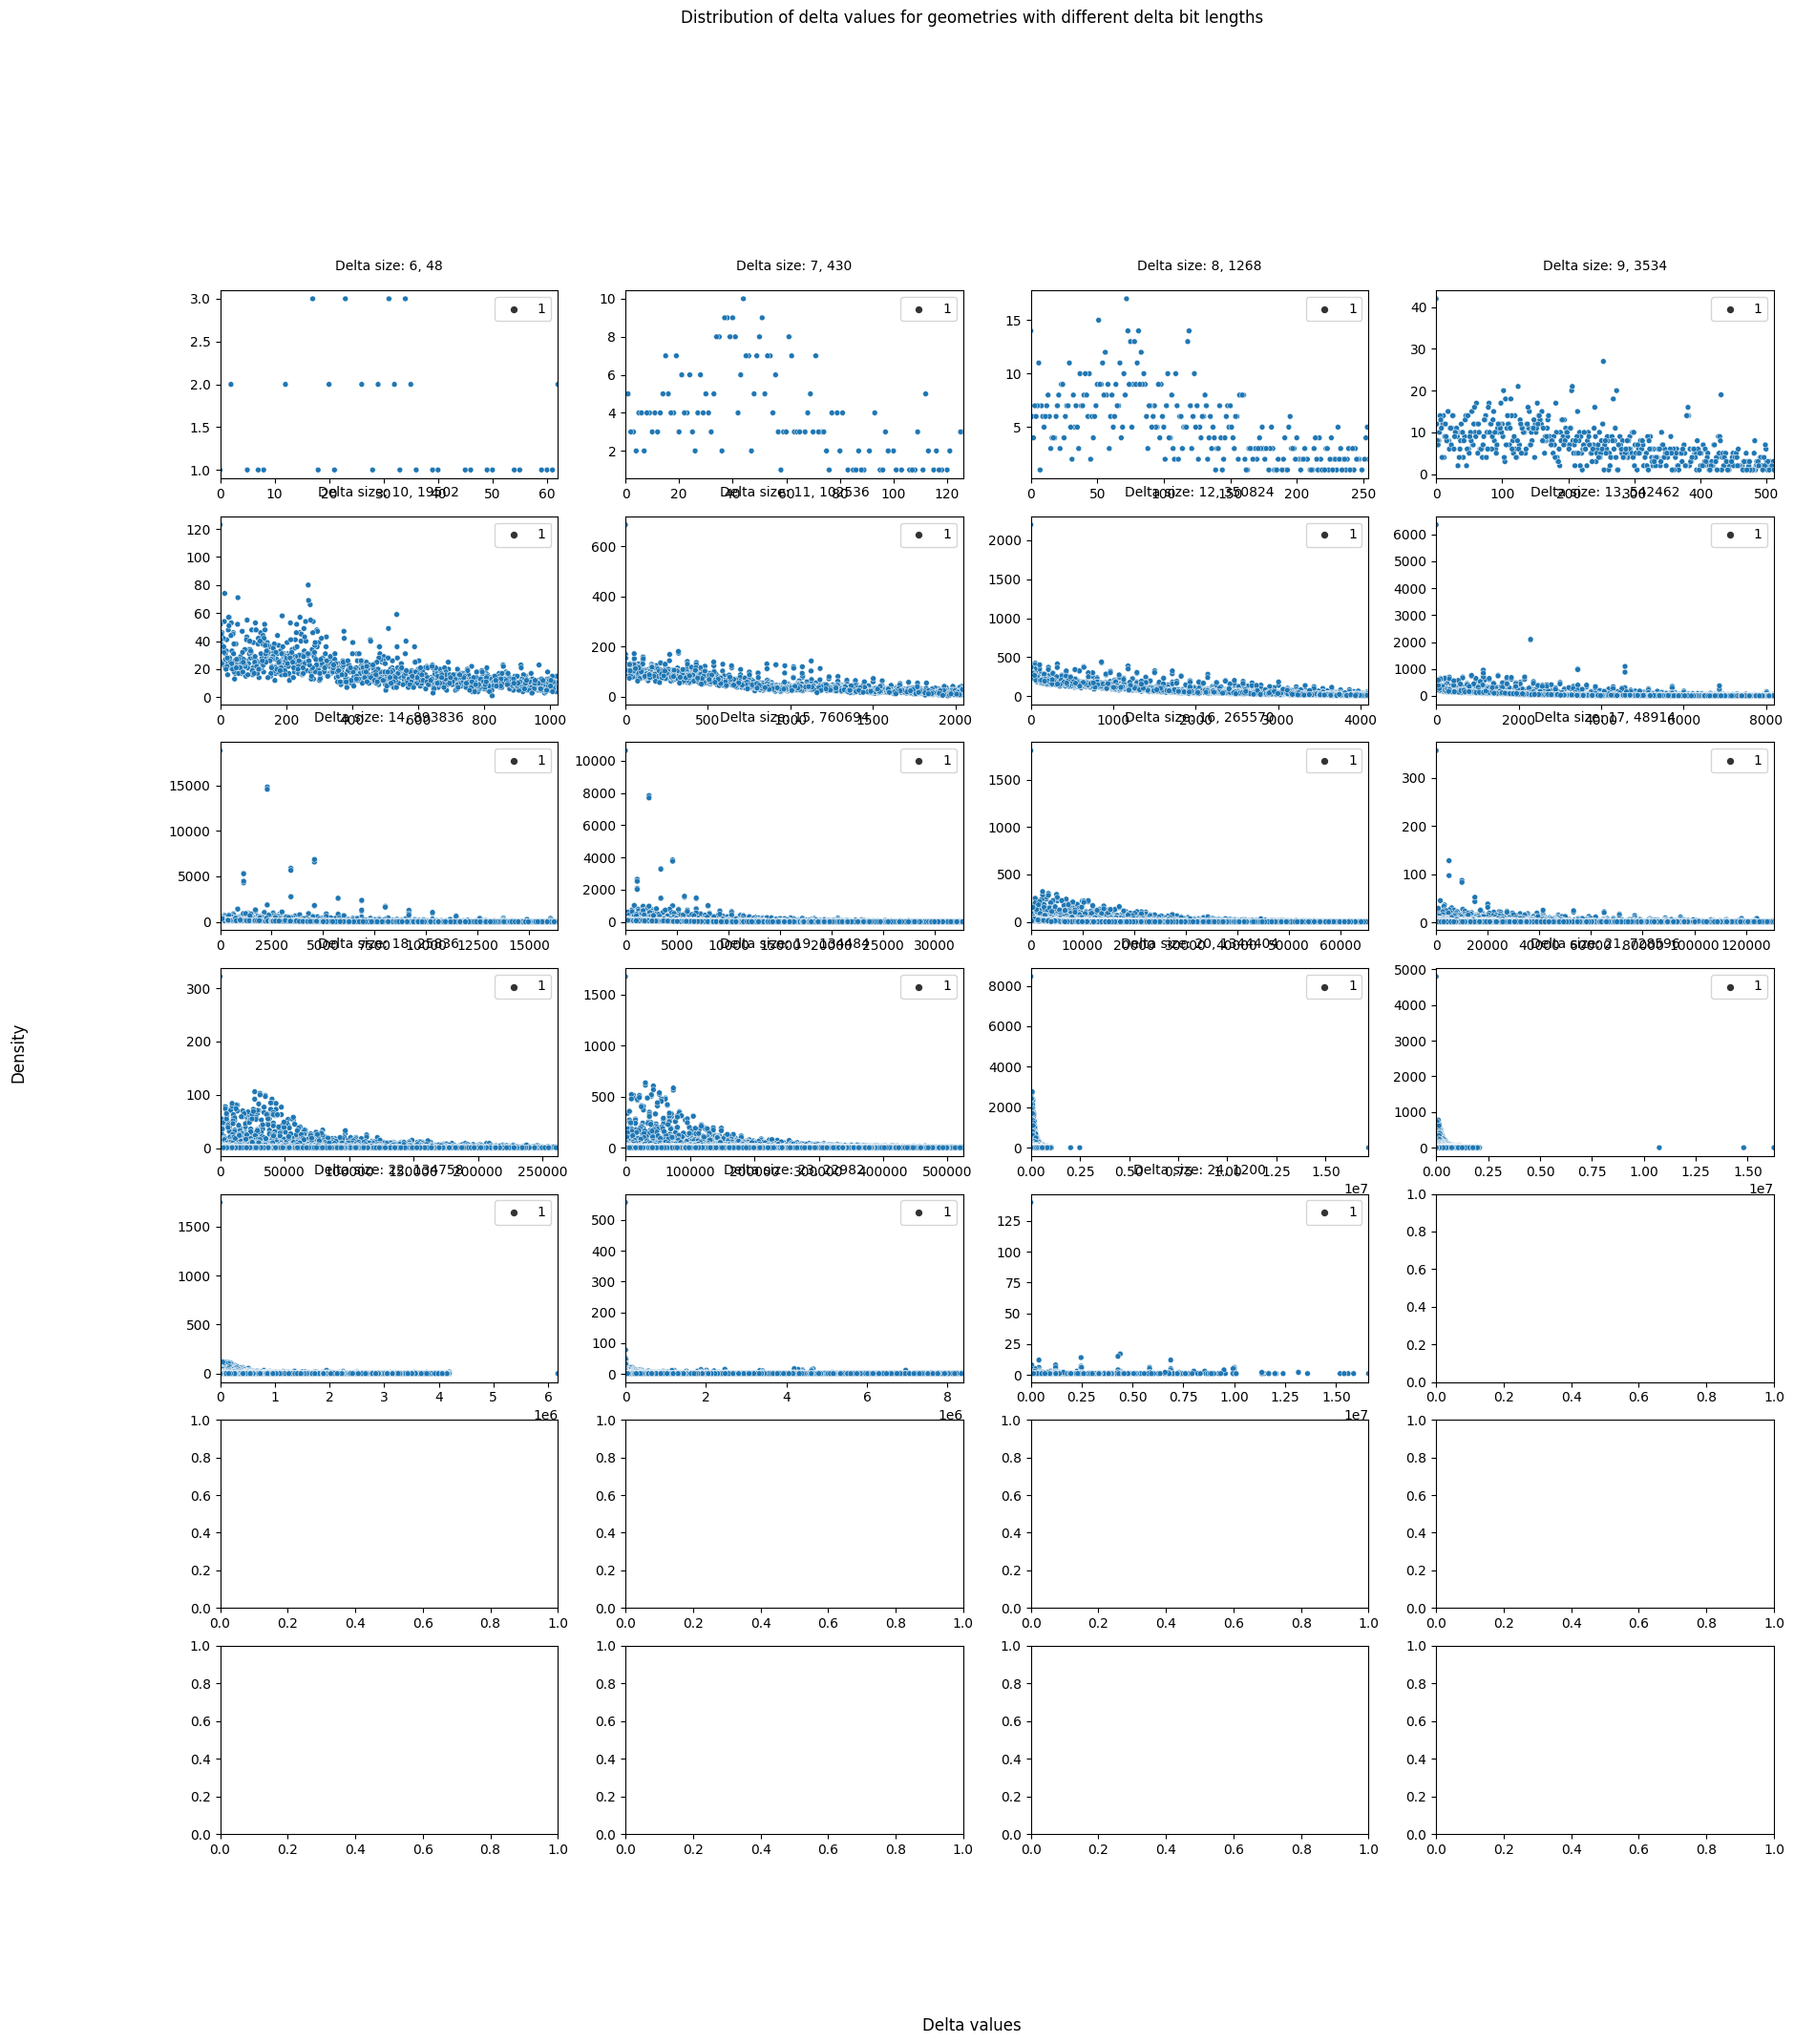

In [12]:
import math
from intersection.plotting import xs, ys
import numpy as np

#sns.kdeplot()




HEIGHT = math.ceil(len(dt_freq_sorted.keys()) / 3)
WIDTH = 4

# #Plot delta distribution for all 
plt.figure(figsize=(HEIGHT * 3, HEIGHT))

fig, axes = plt.subplots(HEIGHT, WIDTH)

for idx, bit_size in enumerate(sorted(dt_freq.keys())):
    chks = chunks[bit_size]
    dts = [item for sublist in chks for item in sublist]

    curr_height, curr_width = idx // WIDTH, idx % WIDTH
    current_axis = axes[curr_height, curr_width]
    current_axis.set_title(f"Delta size: {bit_size}, {len(dts)}", pad=15, fontsize=10)

    data = list(dt_freq[bit_size].items())

    #ax = sns.kdeplot(dts, ax=current_axis)
    ax = sns.scatterplot(x = xs(data), y=ys(data), ax=current_axis, size=1)
    current_axis.set_xlim(0, max(dts))
    current_axis.set(ylabel=None)

fig.supylabel('Density')
fig.supxlabel('Delta values')
fig.suptitle('Distribution of delta values for geometries with different delta bit lengths', y=1.02)
fig.set_figwidth(HEIGHT * 3)
fig.set_figheight(HEIGHT * 3)

# plt.tight_layout()

plt.show()

In [5]:
# for i in range(1):
#     idx = random.randint(0, len(deltas_fp))
#     print("---")
#     print("Delta in FP and LONG:    ", f'{deltas_fp[idx]:.14f}', '        ', deltas_long[idx])
#     print("Converting to f32:       ", f'{struct.unpack("!f", struct.pack("!f", deltas_fp[idx]))[0]:.14f}')
#     print("Required bits:           ", math.ceil(math.log2(deltas_long[idx] + 1)))
#     bin = util.int2ba(deltas_long[idx], length=64)
#     print("ZZ-encoded:              ", end=None)
#     util.pprint(bin, width=200)

#     bin = bitarray()
#     print("FP directly to bin:      ", end=None)
#     bin.frombytes(struct.pack("!d", deltas_fp[idx]))
#     util.pprint(bin, width=200)

#     bin = bitarray()
#     print("FP32 directly to bin:    ", end=None)
#     bin.frombytes(struct.pack("!f", deltas_fp[idx]))
    
#     util.pprint(bin, width=200)

## Calculate Entropy

In [6]:
total_freq = defaultdict(int)

for idx, bit_size in enumerate(sorted(dt_freq.keys())):
    entropy = 0
    chks = chunks[bit_size]
    freq = dt_freq[bit_size]
    tot = sum(freq.values())
    for i in freq:
        total_freq[i] += freq[i]
        p_i = freq[i] / tot
        entropy += - p_i * np.log2(p_i)
    print(bit_size, ": Max comp factor:", entropy)

entropy = 0
tot = sum(total_freq.values())
for i in total_freq:
    p_i = total_freq[i] / tot
    entropy += - p_i * np.log2(p_i)
print("TOT: Max comp factor:", entropy)

6 : Max comp factor: 4.855388542207537
7 : Max comp factor: 6.528535300975453
8 : Max comp factor: 7.6549132614659605
9 : Max comp factor: 8.694491203405272
10 : Max comp factor: 9.767026475202837
11 : Max comp factor: 10.74176505771413
12 : Max comp factor: 11.576289881442472
13 : Max comp factor: 12.044224046133614
14 : Max comp factor: 12.188889707122195
15 : Max comp factor: 13.110059539700227
16 : Max comp factor: 14.11139197431304
17 : Max comp factor: 14.07656918300075
18 : Max comp factor: 11.402043293409436
19 : Max comp factor: 11.151240624106558
20 : Max comp factor: 12.786316612038423
21 : Max comp factor: 13.306315878757884
22 : Max comp factor: 13.534195565743577
23 : Max comp factor: 12.6861006324161
24 : Max comp factor: 8.680618827332802
TOT: Max comp factor: 13.90847500908044


## Encoding Huffman

In [7]:
#%pip install dahuffman
from dahuffman import HuffmanCodec


glob_size_golomb = 0
glob_size_normal = 0
for idx, bit_size in enumerate(sorted(dt_freq.keys())):
    if bit_size == 0:
        continue
    chks = chunks[bit_size]
    dts = [item for sublist in chks for item in sublist]

    # Make non-sparse freq table
    dt_freqs = dict(dt_freq_sorted[bit_size])
    # dt_freqs_full = {}
    # for i in range(max(dts) + 1):
    #     if i in dt_freqs.keys():
    #         dt_freqs_full[i] = dt_freqs[i] + 1
    #     else:
    #         dt_freqs_full[i] = 1

    #print(dt_freqs_full)
    codec = HuffmanCodec.from_frequencies(dt_freqs)

    tot_size_golomb = 0
    tot_size_normal = 0
    for chk in chks:
        encoded = codec.encode(chk)
        USE_TOGGLE_BIT = True
        if USE_TOGGLE_BIT:
            min_size = min(len(encoded) * 8, len(chk) * bit_size)
            tot_size_golomb += min_size + 1
        else:
            tot_size_golomb += len(encoded) * 8
        #codec.decode(encoded)
        tot_size_normal += len(chk) * bit_size

    print(f"---: {bit_size} : DELTAS {len(dts)} ({len(dts) / len(dt_xs + dt_ys)}) :---")
    print("Huf:", tot_size_golomb)
    print("Nor:", tot_size_normal)
    print("Percentage:", tot_size_golomb / tot_size_normal)
    glob_size_golomb += tot_size_golomb
    glob_size_normal += tot_size_normal


print(f"\n---: IN TOTAL :---")
print("Huf:", glob_size_golomb)
print("Nor:", glob_size_normal)
print("Percentage:", glob_size_golomb / glob_size_normal)


---: 6 : DELTAS 48 (8.918819787442228e-06) :---
Huf: 250
Nor: 288
Percentage: 0.8680555555555556
---: 7 : DELTAS 430 (7.989776059583662e-05) :---
Huf: 2886
Nor: 3010
Percentage: 0.9588039867109635
---: 8 : DELTAS 1268 (0.0002356054893849322) :---
Huf: 9898
Nor: 10144
Percentage: 0.9757492113564669
---: 9 : DELTAS 3534 (0.000656648106850434) :---
Huf: 31366
Nor: 31806
Percentage: 0.986166132176319
---: 10 : DELTAS 19502 (0.003623642156139548) :---
Huf: 193018
Nor: 195020
Percentage: 0.9897343862167983
---: 11 : DELTAS 102536 (0.01905208553594117) :---
Huf: 1114432
Nor: 1127896
Percentage: 0.9880627291877975
---: 12 : DELTAS 350824 (0.06518616735645066) :---
Huf: 4144072
Nor: 4209888
Percentage: 0.9843663299356182
---: 13 : DELTAS 542462 (0.10079418374032262) :---
Huf: 6633980
Nor: 7052006
Percentage: 0.940722398704709
---: 14 : DELTAS 893836 (0.16608254590683771) :---
Huf: 11015710
Nor: 12513704
Percentage: 0.880291718583083
---: 15 : DELTAS 760694 (0.1413435979039287) :---
Huf: 1007898

In [8]:
#%pip install golomb_coding

In [9]:
#%pip install dahuffman
from golomb_coding import golomb_coding, optimal_golomb_coding
from bitarray import util


glob_size_golomb = 0
glob_size_normal = 0
for idx, bit_size in enumerate(sorted(dt_freq.keys())):
    if bit_size == 0:
        continue
    chks = chunks[bit_size]
    dts = [item for sublist in chks for item in sublist]

    # Make non-sparse freq table
    dt_freqs = dict(dt_freq_sorted[bit_size])
    # dt_freqs_full = {}
    # for i in range(max(dts) + 1):
    #     if i in dt_freqs.keys():
    #         dt_freqs_full[i] = dt_freqs[i] + 1
    #     else:
    #         dt_freqs_full[i] = 1

    #print(dt_freqs_full)
    delta_mean = sum(dts) / len(dts)
    golden_ratio = (math.sqrt(5) + 1) / 2
    param = max(0, 1 + math.floor(math.log2(math.log(golden_ratio - 1) / math.log(delta_mean /(delta_mean + 1)))))
    print(param)
    tot_size_golomb = 0
    tot_size_normal = 0
    tot = sum(dt_freqs.values())
    for chk in chks:
        encoded = [optimal_golomb_coding(d, dt_freqs[d] / tot) for d in chk]
        golomb_len = sum(list(map(lambda x: len(x), encoded)))
        #print(encoded)
        tot_size_golomb += golomb_len
        #codec.decode(encoded)
        tot_size_normal += len(chk) * bit_size
    print(encoded[0])
    bin = util.int2ba(chk[0], length=bit_size)
    util.pprint(bin, width=200)

    print(f"---: {bit_size} : DELTAS {len(dts)} ({len(dts) / len(dt_xs + dt_ys)}) :---")
    print("Huf:", tot_size_golomb)
    print("Nor:", tot_size_normal)
    print("Percentage:", tot_size_golomb / tot_size_normal)
    glob_size_golomb += tot_size_golomb
    glob_size_normal += tot_size_normal


print(f"\n---: IN TOTAL :---")
print("Huf:", glob_size_golomb)
print("Nor:", glob_size_normal)
print("Percentage:", glob_size_golomb / glob_size_normal)


4
0001001
bitarray('100010')
---: 6 : DELTAS 48 (8.918819787442228e-06) :---
Huf: 311
Nor: 288
Percentage: 1.0798611111111112
5
101111
bitarray('0001111')
---: 7 : DELTAS 430 (7.989776059583662e-05) :---
Huf: 3147
Nor: 3010
Percentage: 1.045514950166113
6
011000011
bitarray('10011111')
---: 8 : DELTAS 1268 (0.0002356054893849322) :---
Huf: 10662
Nor: 10144
Percentage: 1.051064668769716
7
11101000011
bitarray('11010100 0')
---: 9 : DELTAS 3534 (0.000656648106850434) :---
Huf: 33096
Nor: 31806
Percentage: 1.0405583852103377
8
1001010011
bitarray('00010100 11')
---: 10 : DELTAS 19502 (0.003623642156139548) :---
Huf: 202476
Nor: 195020
Percentage: 1.0382319762075685
9
1110101001
bitarray('00101000 010')
---: 11 : DELTAS 102536 (0.01905208553594117) :---
Huf: 1154176
Nor: 1127896
Percentage: 1.0233000205692724
10
11010000010011
bitarray('10111101 0010')
---: 12 : DELTAS 350824 (0.06518616735645066) :---
Huf: 4229642
Nor: 4209888
Percentage: 1.0046922863506107
10
11000001111110
bitarray('100